In [1]:


import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats


%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)
sns.set(rc={'figure.figsize':(12,6)})


/mnt/activeCell-ACDC
README.md					log
ac_acdc_env					nohup.out
acdc_large_cls_test_slim_coco_format.json	notebooks
acdc_large_cls_test_slim_coco_format.json.lock	output
al_output					pipeline_configs
coco_instances_results.json			requirements.txt
data						shell_scripts
experiments					src
instances_predictions.pth			utils
jupyter_notebooks				wandb


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./experiments/results"

def load_experiment_results(path, experiment_dir, filename):
    
    path = os.path.join(path,experiment_dir)

    directory = os.fsencode(path)
    df_full = None

    for file in os.listdir(directory):
        fn = os.fsdecode(file)
        if fn.find(filename) != -1: 

            df = pd.read_csv(os.path.join(path, fn))

            if len(df) == 1:
                continue

            #print(fn)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
        else:
            print("file ignored:", fn)
    
    return df_full

def latex_pd(df):
    df = df.round(5)
    return df.to_latex(index=False)

In [3]:
df_tta = load_experiment_results(path, "tta_stability", "results")
df_tta["u_type"] = "TTA"
df_mcd = load_experiment_results(path, "mc_drop_stability", "mc_drop_gridseach")
df_mcd["u_type"] = "MCD"
df =  pd.concat([df_tta, df_mcd])

file ignored: .ipynb_checkpoints
file ignored: old
file ignored: .ipynb_checkpoints


In [4]:
df["frame_id"] = df["image_id"].str.split("_").str[-1].astype("int")
df["experiment"] = df["image_id"].str.split("_").str[:-1].str.join("_")
df["certainty"] = 1 - df["agg_uncertainty"]

#df = df[df["num_mc_samples"] == 30]

df.head()

Unnamed: 0  num_mc_samples  max_noise  model_train_size  \
0           0              30      0.001                15   
1           1              30      0.001                15   
2           2              30      0.001                15   
3           3              30      0.001                15   
4           4              30      0.001                15   

                                            image_id  run_id  agg_uncertainty  \
0  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       0         0.550150   
1  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       1         0.719745   
2  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       2         0.575471   
3  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       3         0.619881   
4  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       4         0.603994   

  u_type  dropout_prob  frame_id  \
0    TTA           NaN         0   
1    TTA           NaN         0   
2    TTA           NaN         0   
3    TTA           NaN         0   
4    TTA           NaN         0   

                                        experiment  certainty  
0  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.449850  
1  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.280255  
2  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.424529  
3  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.380119  
4  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.396006

In [5]:
avg_var = df[["image_id", "u_type", "certainty","model_train_size"]].groupby(["image_id","model_train_size", "u_type"]).agg("var").reset_index().groupby(["model_train_size", "u_type"]).agg("mean")
var_ds = df[df["run_id"] == 0][["image_id", "u_type", "certainty","model_train_size"]].groupby(["image_id", "u_type","model_train_size"]).agg("mean").reset_index().groupby(["model_train_size", "u_type"]).agg("var")
print(avg_var.head())
print(var_ds.head())
df_new = pd.merge(var_ds,avg_var, on=["model_train_size", "u_type"]).reset_index()
df_new["noise_portion"] = df_new["certainty_y"]/df_new["certainty_x"] 



print(latex_pd(df_new))



                         certainty
model_train_size u_type           
15               MCD      0.002390
                 TTA      0.000943
240              MCD      0.000238
                 TTA      0.000430
3000             MCD      0.000160
                         certainty
model_train_size u_type           
15               MCD      0.003631
                 TTA      0.002995
240              MCD      0.005776
                 TTA      0.005479
3000             MCD      0.005767
\begin{tabular}{rlrrr}
\toprule
 model\_train\_size & u\_type &  certainty\_x &  certainty\_y &  noise\_portion \\
\midrule
               15 &    MCD &      0.00363 &      0.00239 &        0.65823 \\
               15 &    TTA &      0.00299 &      0.00094 &        0.31503 \\
              240 &    MCD &      0.00578 &      0.00024 &        0.04119 \\
              240 &    TTA &      0.00548 &      0.00043 &        0.07856 \\
             3000 &    MCD &      0.00577 &      0.00016 &        0.02775 \\
 

/tmp/ipykernel_865952/693334524.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_var = df[["image_id", "u_type", "certainty","model_train_size"]].groupby(["image_id","model_train_size", "u_type"]).agg("var").reset_index().groupby(["model_train_size", "u_type"]).agg("mean")
/tmp/ipykernel_865952/693334524.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  var_ds = df[df["run_id"] == 0][["image_id", "u_type", "certainty","model_train_size"]].groupby(["image_id", "u_type","model_train_size"]).agg("mean").reset_index().groupby(["model_train_size", "u_type"]).agg("var")
/tmp/ipykernel_865952/2167838137.py

/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5 3000


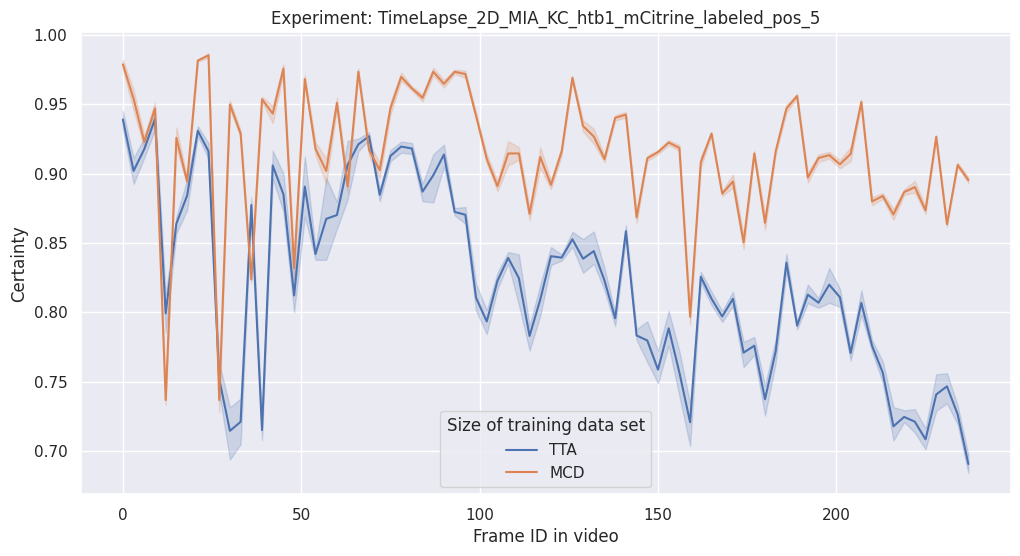

acdc_data2_F016_pos_3 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


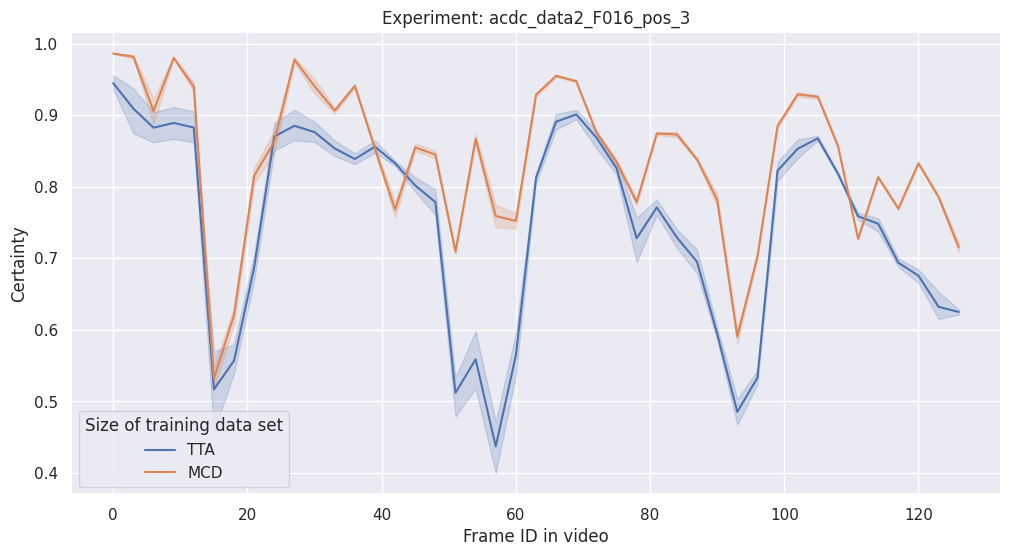

acdc_data2_kurt_306-3_0_20201028_pos_1 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


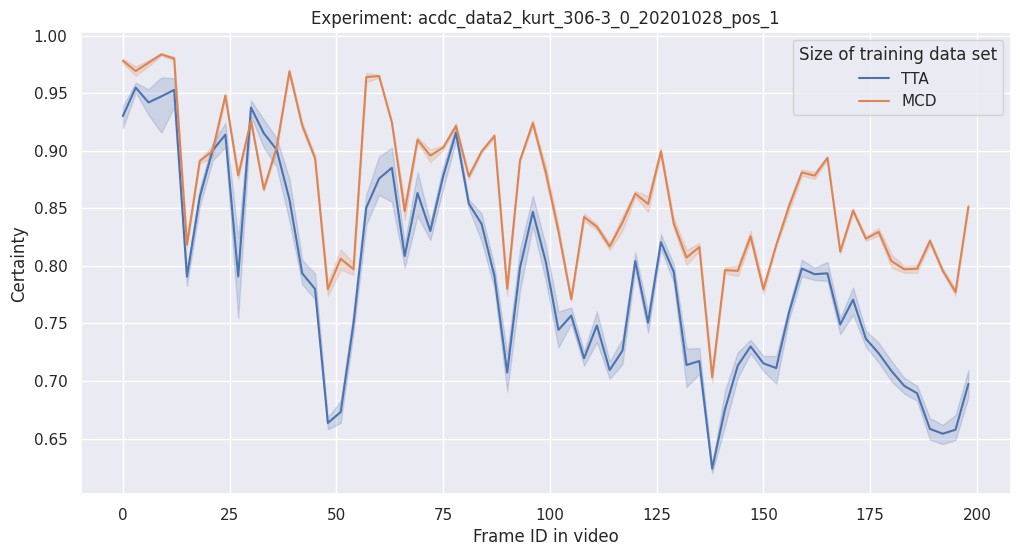

acdc_data3_20210722_pos_18 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


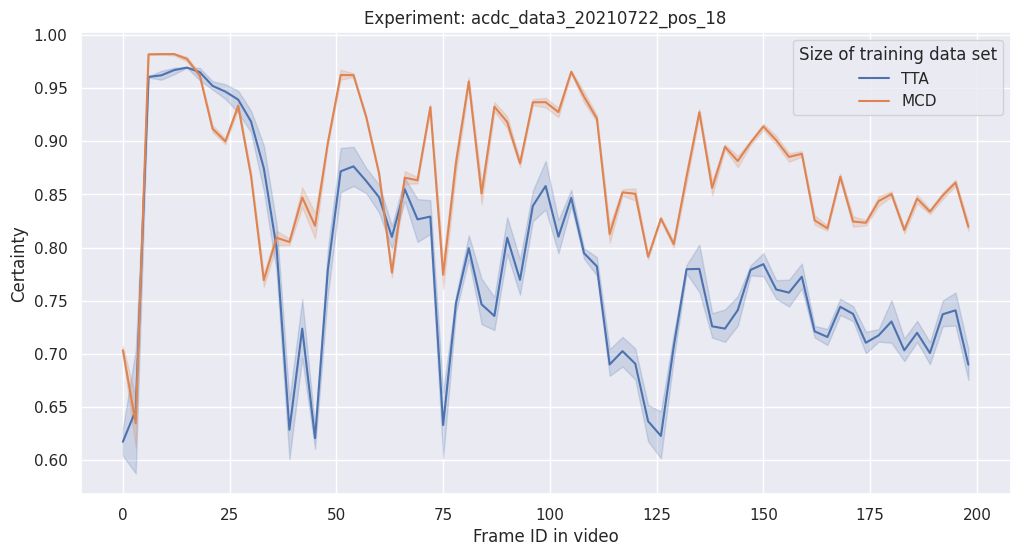

acdc_data3_20210722_pos_2 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


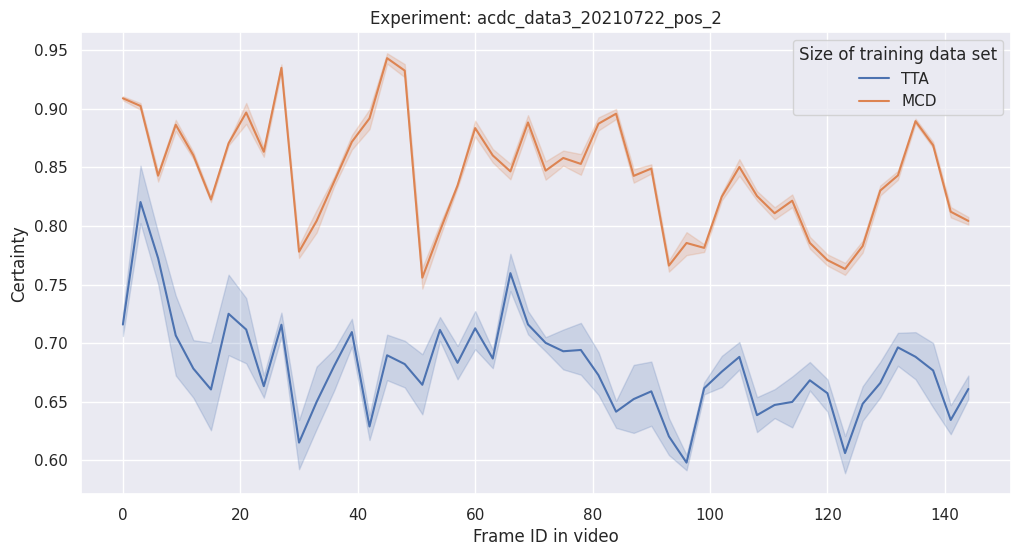

acdc_data3_20210722_pos_5 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


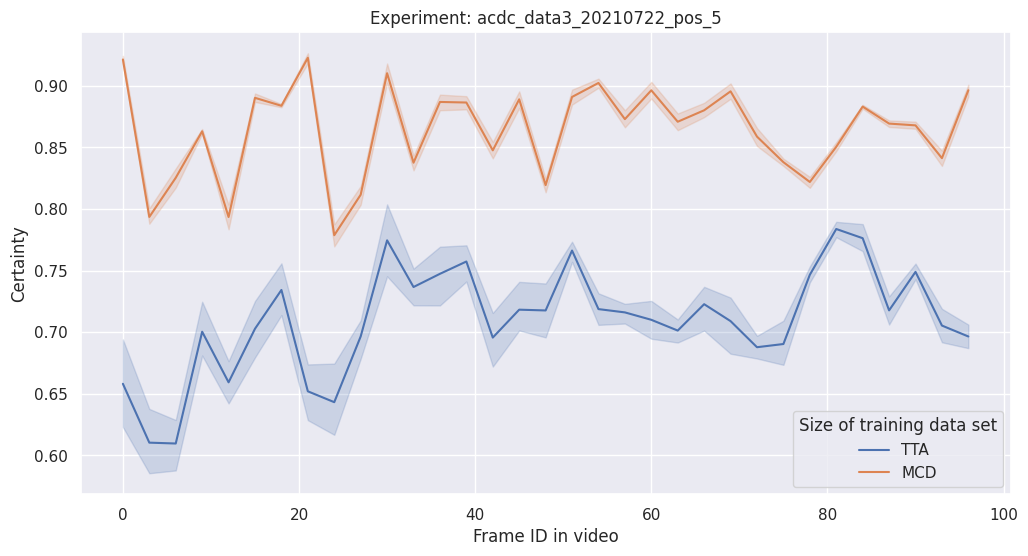

acdc_data3_20211029_pos_1 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


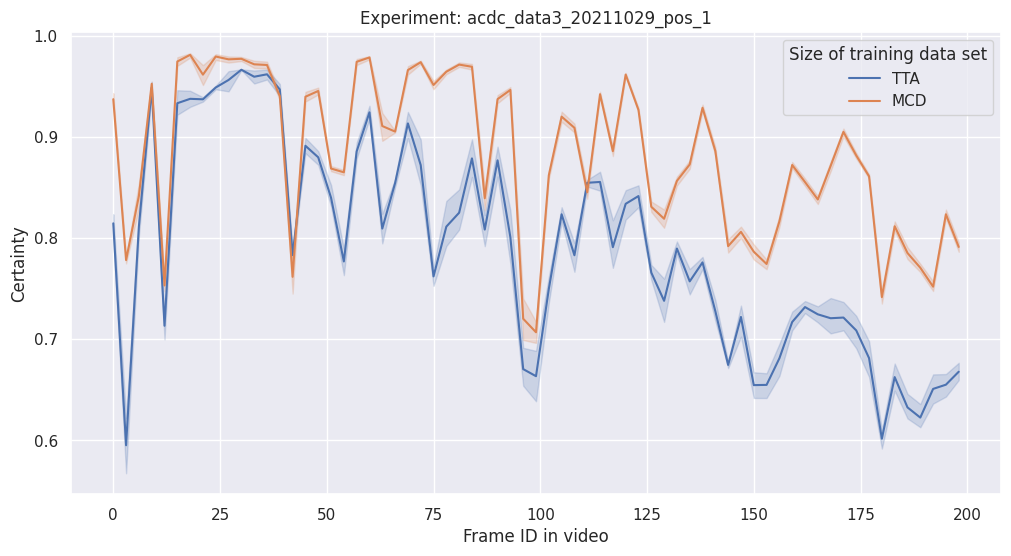

acdc_data3_20211029_pos_4 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


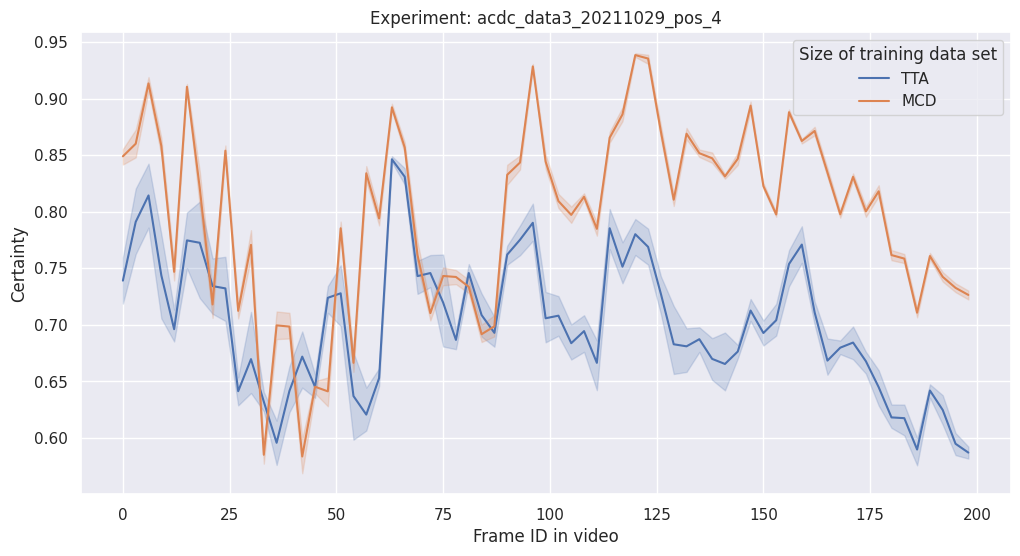

acdc_data3_Yagya_SCD_WT_pos_5 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


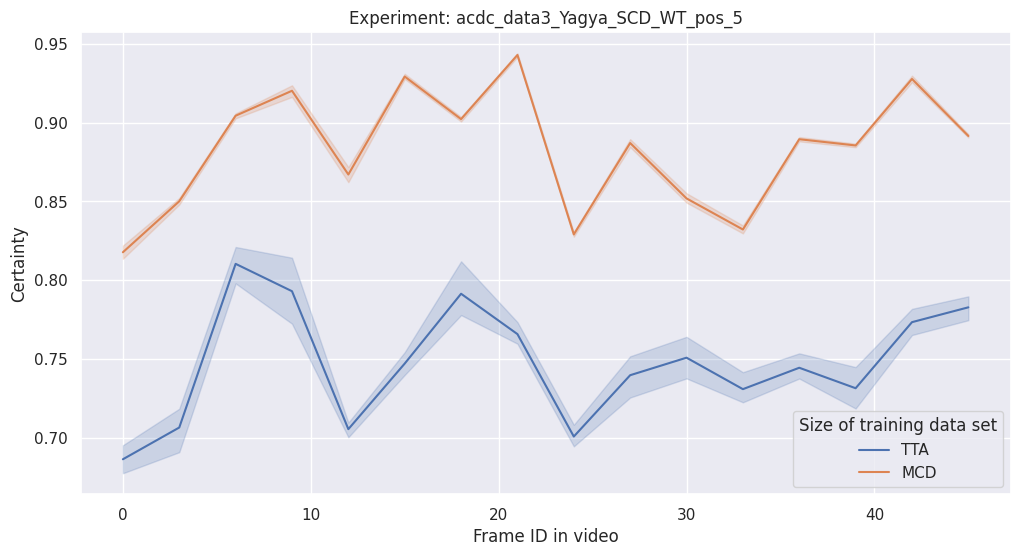

acdc_data3_Yagya_SCD_WT_pos_6 3000


/tmp/ipykernel_865952/1841500850.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())


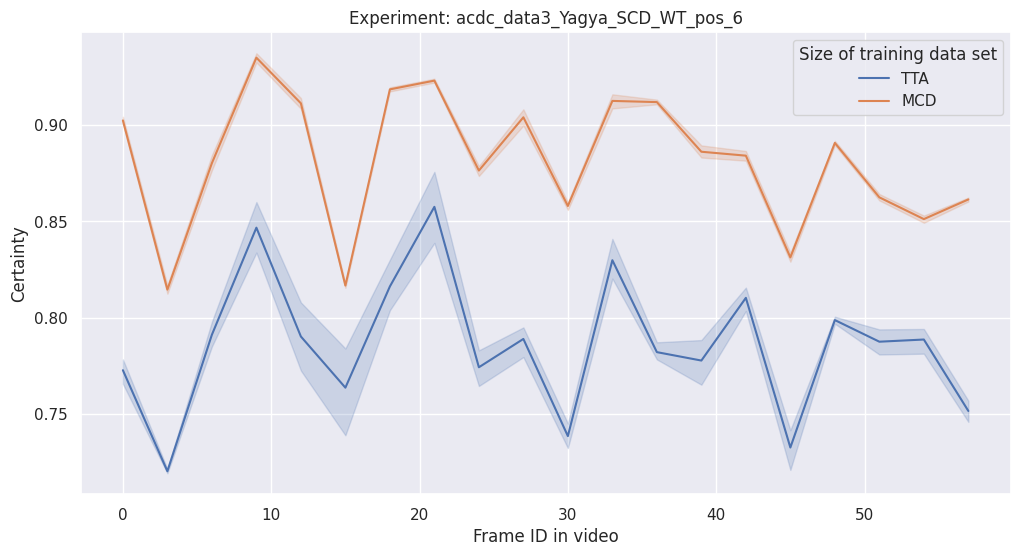

In [6]:
for experiment in df["experiment"].unique():
    for model_train_size in df["model_train_size"].unique():
        if model_train_size != 3000:
            continue
        df_tmp = df[df["experiment"] == experiment]
        df_tmp = df_tmp[df_tmp["model_train_size"] == model_train_size]
        print(experiment,model_train_size)
        plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="u_type",palette=sns.color_palette())
        plot.set(xlabel ="Frame ID in video", ylabel = "Certainty", title =f'Experiment: {experiment}')
        plt.legend(title='Size of training data set')
        plt.show()

In [7]:
#sns.pairplot(df)

In [8]:
dataset = ACDC_LARGE_CLS
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get("acdc_large_cls_test_slim")

registering acdc_large dataset
registering acdc_large_cls dataset


In [9]:
data_categories = []
for data_json in test_data:
    categories = [annotation["category_id"] for annotation in data_json["annotations"]]
    counts = {i:categories.count(i) for i in range(3)}
    data_categories.append(
        {
            "image_id": data_json["image_id"],
            "G1": counts[0]/len(data_json["annotations"]),
            "mother": counts[1]/len(data_json["annotations"]),
            "bud": counts[2]/len(data_json["annotations"]),
            "num_cells": len(data_json["annotations"])
        }
    )
    
category_df = pd.DataFrame.from_records(data_categories)
df_new = pd.merge(df, category_df, left_on="image_id", right_on="image_id")
df_new = df_new[df_new["model_train_size"] == 3000]
df_new.head()

Unnamed: 0  num_mc_samples  max_noise  model_train_size  \
5           0              30      0.001              3000   
6           1              30      0.001              3000   
7           2              30      0.001              3000   
8           3              30      0.001              3000   
9           4              30      0.001              3000   

                                            image_id  run_id  agg_uncertainty  \
5  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       0         0.054427   
6  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       1         0.076532   
7  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       2         0.062522   
8  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       3         0.057448   
9  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0       4         0.054073   

  u_type  dropout_prob  frame_id  \
5    TTA           NaN         0   
6    TTA           NaN         0   
7    TTA           NaN         0   
8    TTA           NaN         0   
9    TTA           NaN         0   

                                        experiment  certainty   G1  mother  \
5  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.945573  0.0     0.5   
6  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.923468  0.0     0.5   
7  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.937478  0.0     0.5   
8  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.942552  0.0     0.5   
9  TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5   0.945927  0.0     0.5   

   bud  num_cells  
5  0.5          2  
6  0.5          2  
7  0.5          2  
8  0.5          2  
9  0.5          2

<Figure size 1200x600 with 0 Axes>

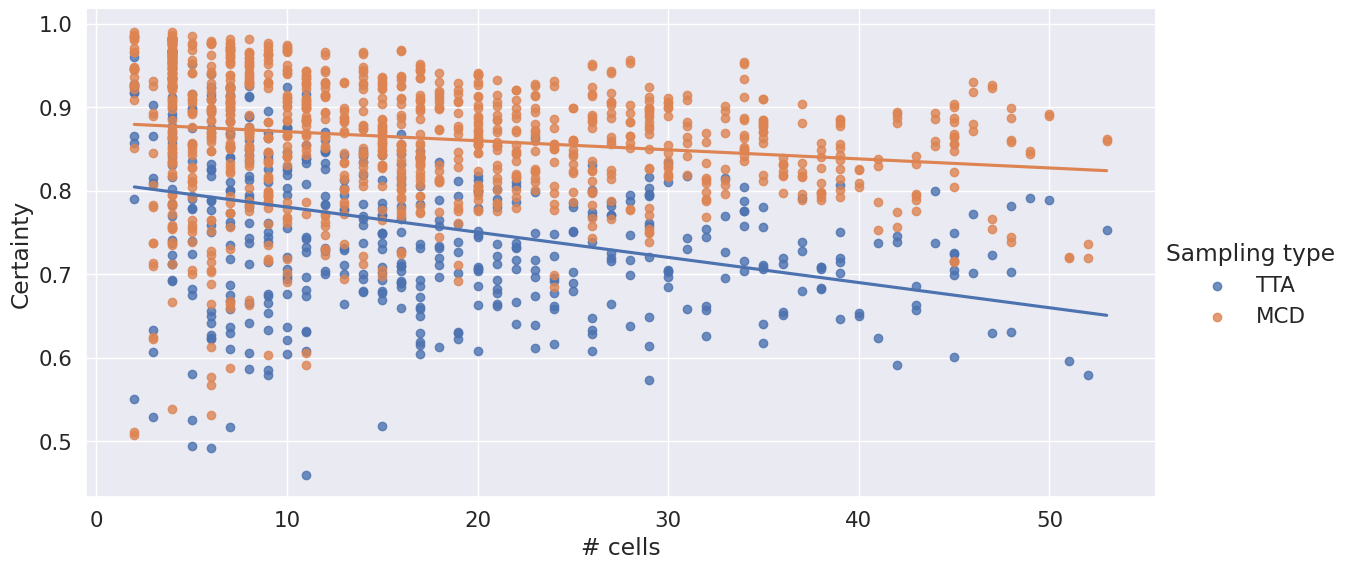

TTA -0.4213477880186771 4.4289668237643096e-110
MCD -0.26672506863828815 2.317259575690064e-165


In [10]:
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
df_new["Sampling type"] = df_new["u_type"]
df_new["Certainty"] = df_new["certainty"]
df_new["# cells"] = df_new["num_cells"]
sns.lmplot(data=df_new[df_new["run_id"] == 0], x="# cells", y="Certainty", hue="Sampling type", height=6, aspect=2, ci=None)
plt.show()


tta_corr = stats.spearmanr(df_new[df_new["u_type"] == "TTA"]["Certainty"].values, df_new[df_new["u_type"] == "TTA"]["# cells"].values)
mcd_corr = stats.spearmanr(df_new[df_new["u_type"] == "MCD"]["Certainty"].values, df_new[df_new["u_type"] == "MCD"]["# cells"].values)
print("TTA", tta_corr.statistic, tta_corr.pvalue)
print("MCD", mcd_corr.statistic, mcd_corr.pvalue)

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


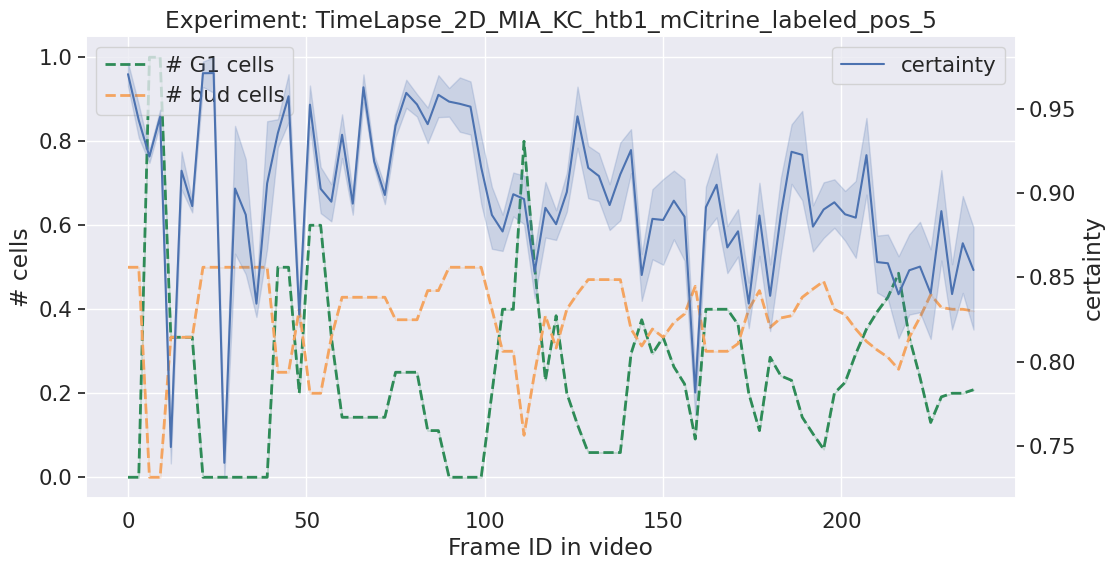

acdc_data2_F016_pos_3


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


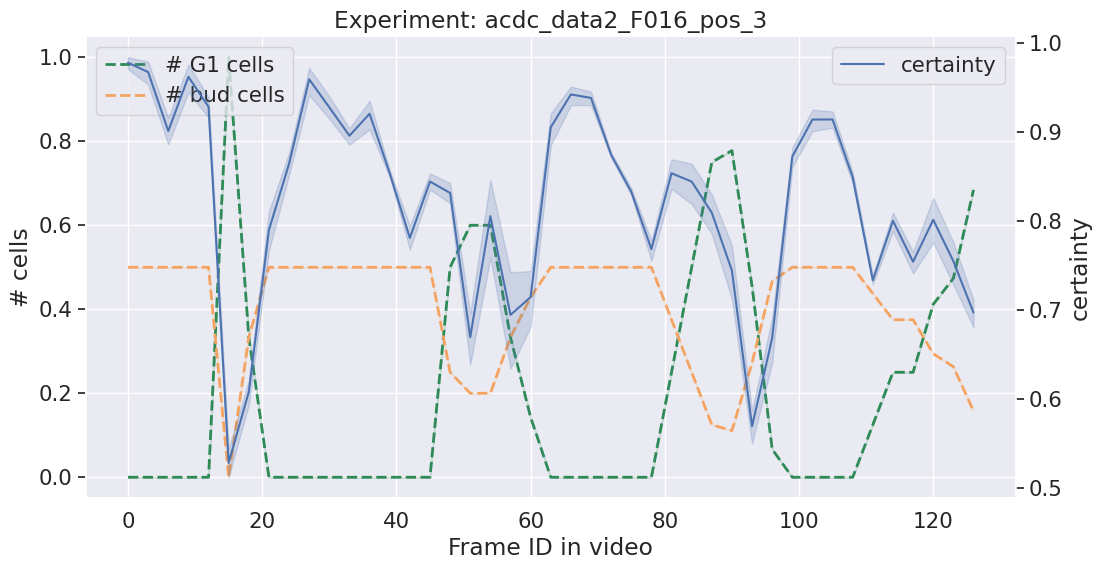

acdc_data2_kurt_306-3_0_20201028_pos_1


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


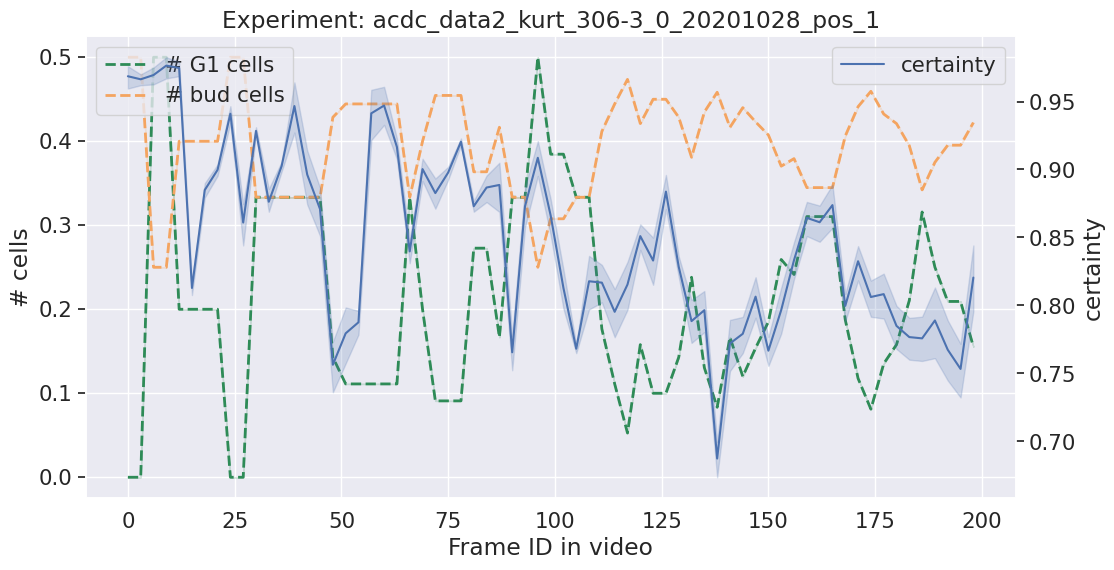

acdc_data3_20210722_pos_18


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


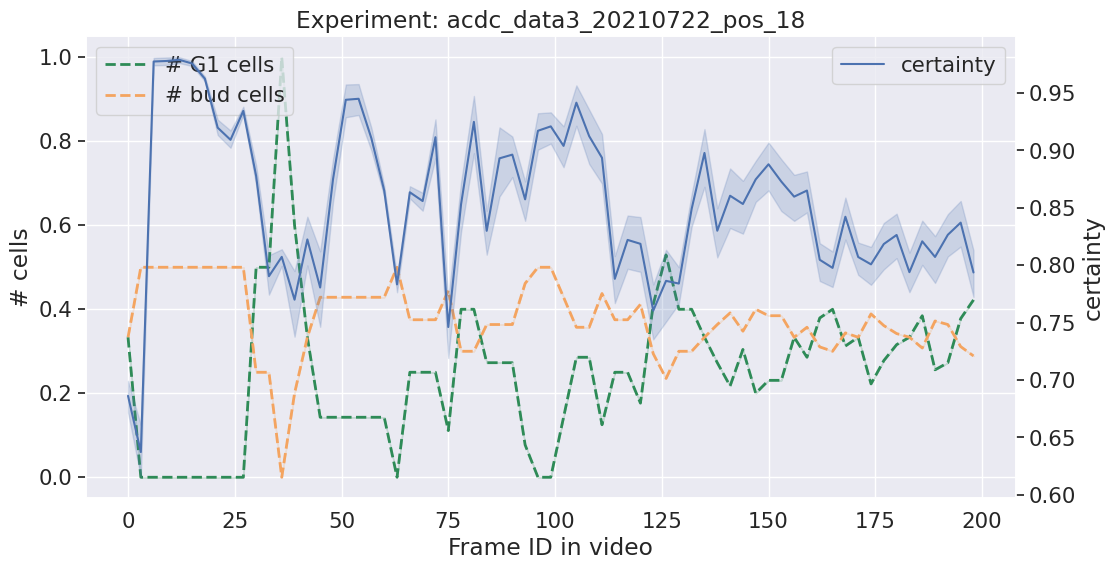

acdc_data3_20210722_pos_2


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


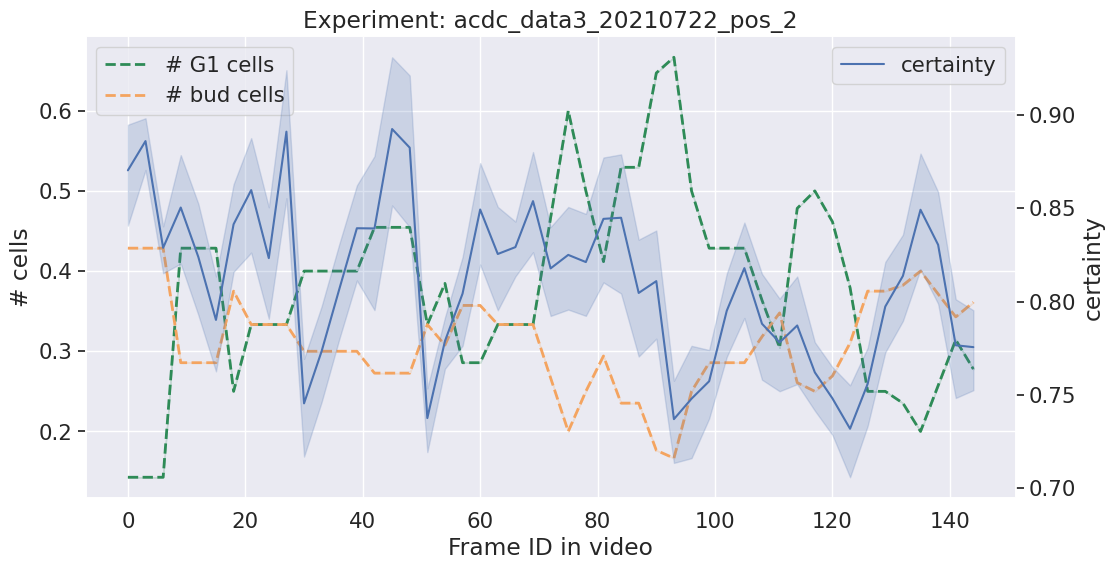

acdc_data3_20210722_pos_5


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


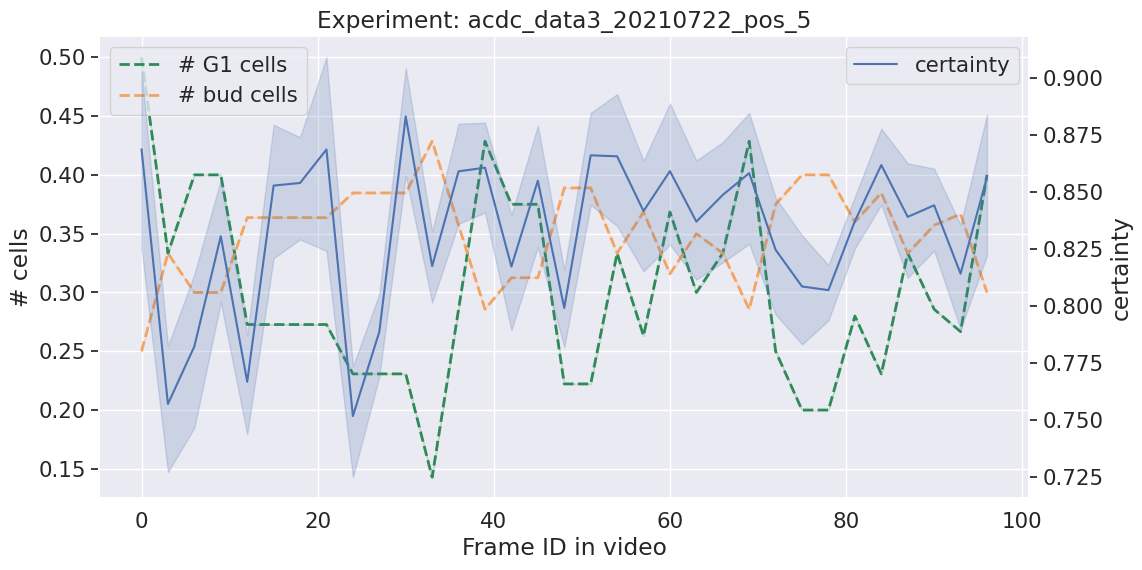

acdc_data3_20211029_pos_1


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


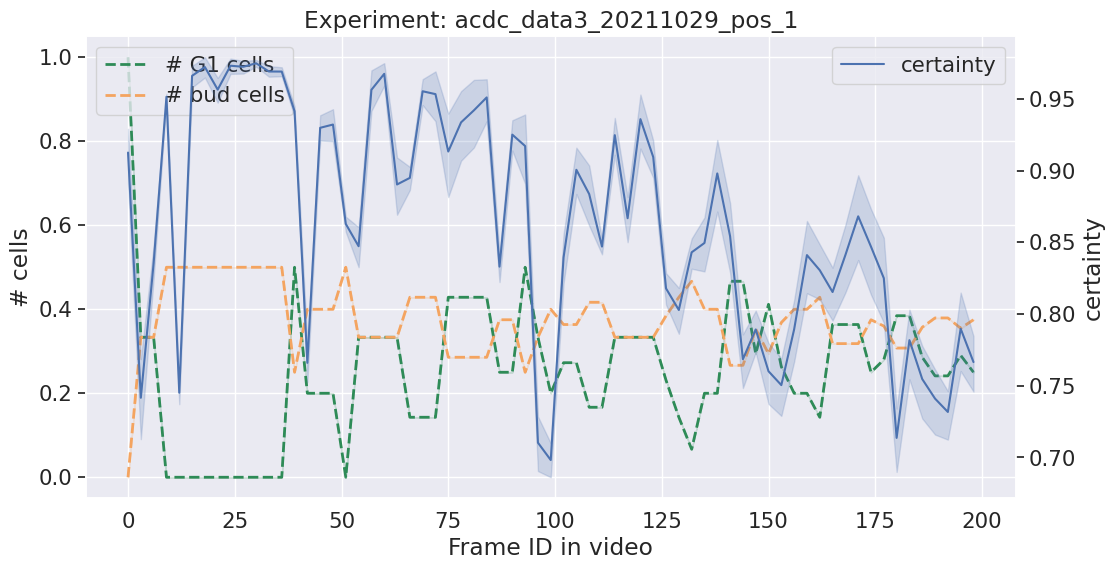

acdc_data3_20211029_pos_4


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


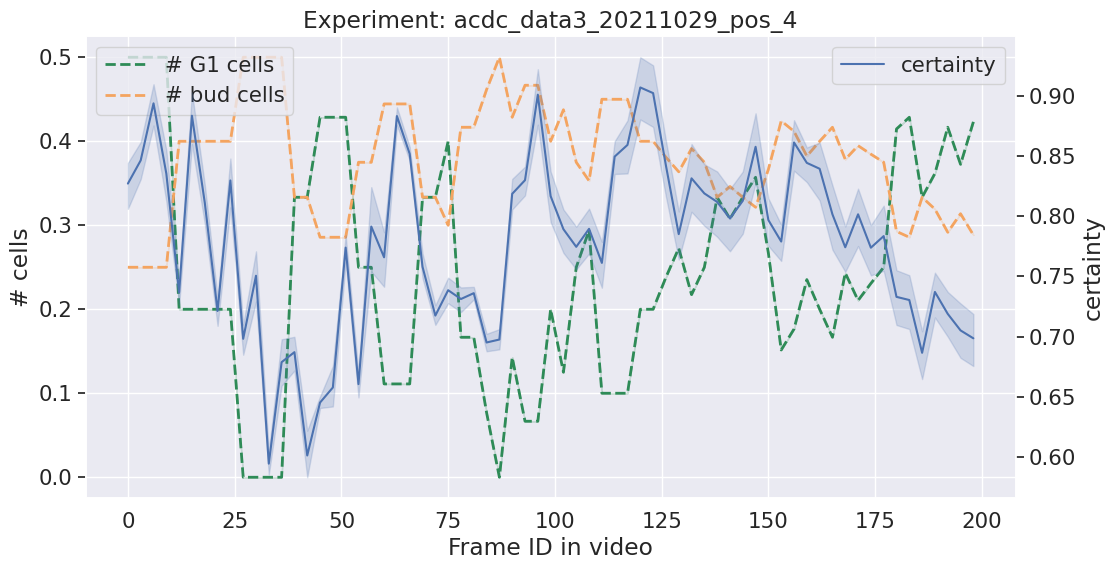

acdc_data3_Yagya_SCD_WT_pos_5


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


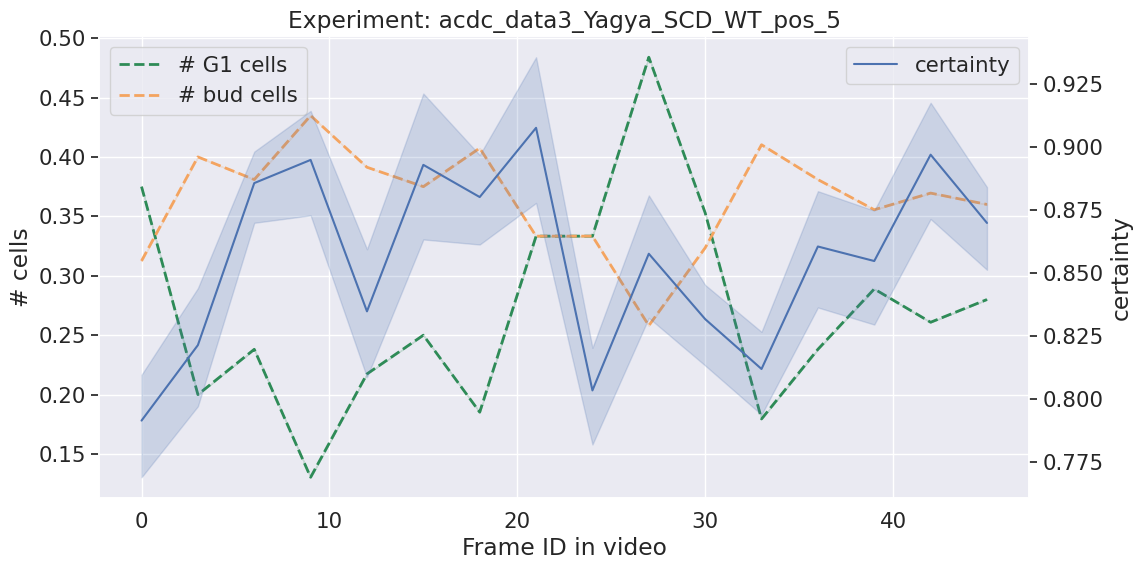

acdc_data3_Yagya_SCD_WT_pos_6


/tmp/ipykernel_865952/3633324385.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


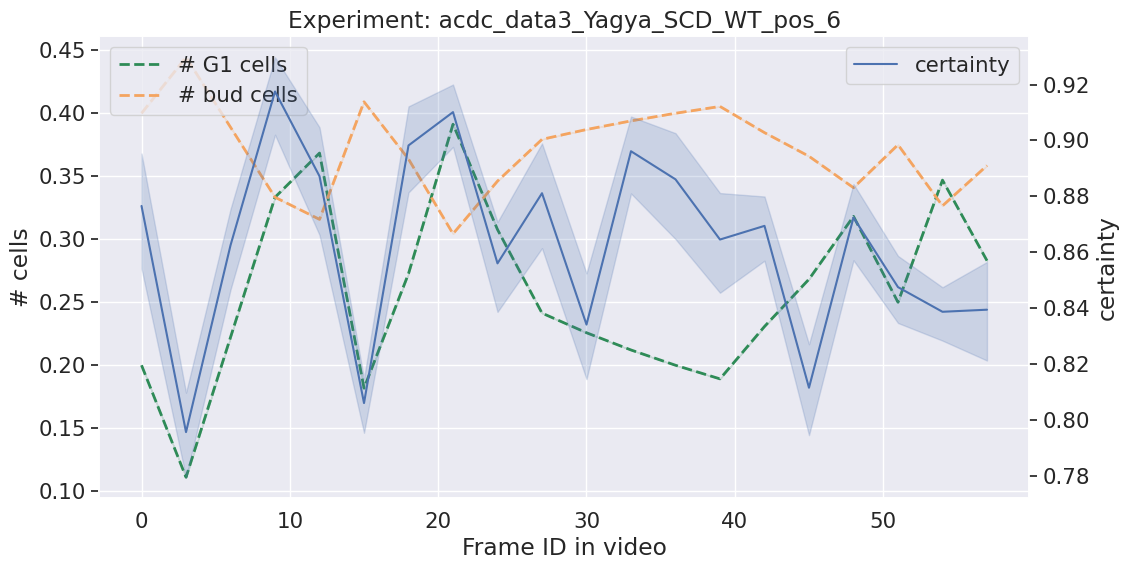

In [11]:
experiment = "acdc_data2_F016_pos_3"

for experiment in df_new["experiment"].unique():
    df_tmp = df_new[df_new["experiment"] == experiment]
    print(experiment)
    fig = plt.figure()
    ax2 = plt.subplot()
    g1 = sns.lineplot(data=df_tmp, x="frame_id", y="G1", color="seagreen", ax=ax2, label="# G1 cells",linewidth = 2, linestyle = "dashed")
    buds = sns.lineplot(data=df_tmp, x="frame_id", y="bud", color="sandybrown", ax=ax2, label="# bud cells",linewidth = 2, linestyle = "dashed")
    ax = plt.twinx()
    plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")
    ax2.set_ylabel("# cells")


    #lns = [plot, g1, buds]
    #labs = [l.get_label() for l in lns]
    #ax2.legend(lns, labs, loc=0)


    ax2.set(xlabel ="Frame ID in video", title =f'Experiment: {experiment}')
    plot.legend()
    ax.grid(False)
    ax2.grid(True)
    ax2.legend(loc='upper left')
    ax.legend(loc='upper right')
    #plt.legend(title='Size of training data set')
    plt.show()

In [12]:
df_new[df_new["u_type"] == "MCD"][["G1", "mother", "bud", "certainty"]].corr()

tta_corr = stats.spearmanr(df_new[df_new["u_type"] == "TTA"]["Certainty"].values, df_new[df_new["u_type"] == "TTA"]["G1"].values)
mcd_corr = stats.spearmanr(df_new[df_new["u_type"] == "MCD"]["Certainty"].values, df_new[df_new["u_type"] == "MCD"]["G1"].values)
print("TTA", tta_corr.statistic, tta_corr.pvalue)
print("MCD", mcd_corr.statistic, mcd_corr.pvalue)

TTA -0.34966945728773774 4.350985452999218e-74
MCD -0.19714318707660358 9.795758152384649e-90


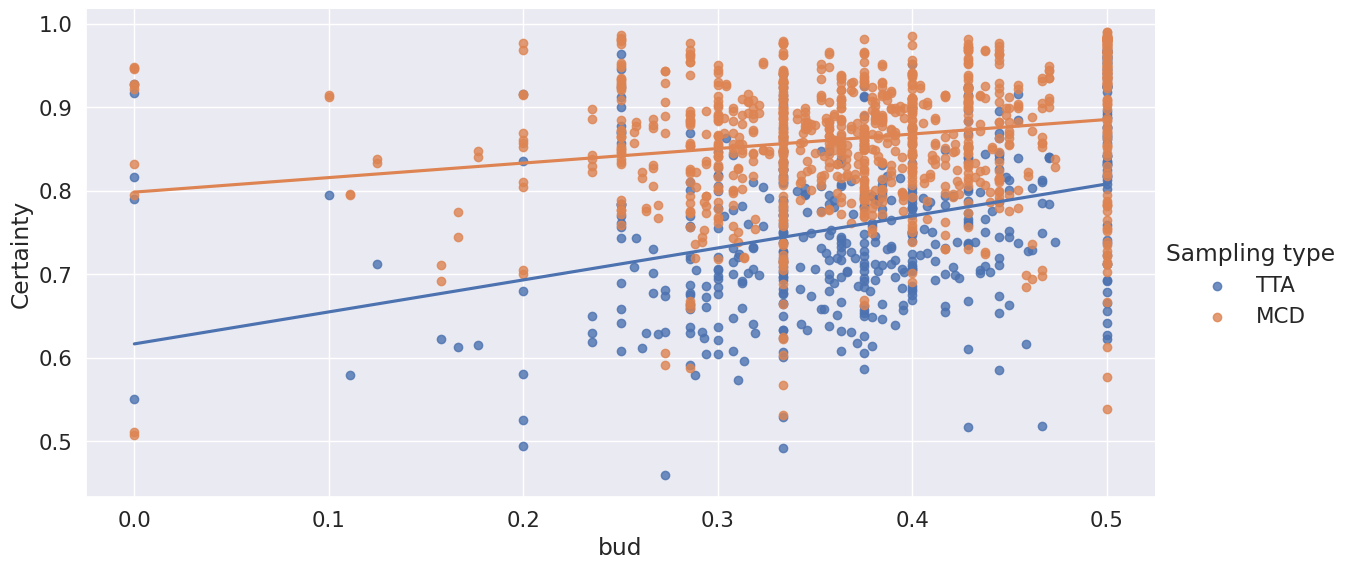

In [13]:
sns.lmplot(data=df_new[df_new["run_id"] == 0], x="bud", y="Certainty", hue="Sampling type", height=6, aspect=2, ci=None)